In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib as mpl 
#mpl.use("module://mplcairo.qt") 
from mplcairo import operator_t
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def get_bins(df, column, n_bins):
    min_v = df[column].min()
    max_v = df[column].max()
    array = []
    
    for i in range(n_bins+1):
        step = max_v/n_bins
        array.append(int(round(step*i, 0)))
    
    return array

In [3]:
## Get the names and open data
data_domicilio_path = ('./data/CENSO/Domicilio02_PB.csv') 

with open(data_domicilio_path, "r", encoding="latin-1") as myfile:
    for i in range(1):
        line = next(myfile).strip()
        names = line.split(';')


data = pd.read_csv(data_domicilio_path,                  
                sep=';', 
                header=None, 
                names=names,
                skiprows=1,
                encoding="latin-1",
                dtype={'Cod_setor': str})

In [4]:
## Open SHP
setores = gpd.read_file('./data/shp/jp_shp.shp')
setores = setores.to_crs(epsg=3857)

In [5]:
border = setores
border['new_column'] = 0
border = border.dissolve(by='new_column')
border = border[['geometry']]
border['geometry'] = border['geometry'].buffer(0.0001)

In [6]:
# Select only the data we are interested in
#v001 = Moradores em domicilios particular e domicilios coletivos
moradores = data[['Cod_setor', 'V001']]
moradores = moradores.rename(columns={'V001': 'MORADORES'})

setores = setores[['geometry', 'NM_BAIRRO', 'CD_GEOCODI']]

In [7]:
# Set the same inde
moradores.set_index('Cod_setor', inplace=True)
setores.set_index('CD_GEOCODI', inplace=True)

In [8]:
setores = setores.join(moradores)

In [9]:
bairros = setores.dissolve(by='NM_BAIRRO', aggfunc='sum')

In [10]:
bairros_interesse = ['Torre', 'Tambauzinho', 'Expedicionários', 'Miramar', 'Pedro Gondim', 'Estados']
setores_recorte = setores.loc[setores['NM_BAIRRO'].isin(bairros_interesse)]

,geometry,NM_BAIRRO,MORADORES,area,densidade
CD_GEOCODI,,,,,
250750705000153,"POLYGON ((-3880337.824 -793550.572, -3880322.8...",Estados,641.0,13.749783,46.618916
250750705000154,"POLYGON ((-3880206.504 -793549.049, -3880131.9...",Estados,965.0,15.160763,63.651151
250750705000155,"POLYGON ((-3879433.625 -794026.389, -3879502.9...",Estados,712.0,24.450141,29.120486
250750705000156,"POLYGON ((-3879858.613 -794140.257, -3879860.2...",Estados,839.0,29.923481,28.038182
250750705000157,"POLYGON ((-3880720.755 -793909.100, -3880719.7...",Estados,550.0,20.538422,26.779078
...,...,...,...,...,...
250750705000728,"POLYGON ((-3880072.655 -794926.335, -3879957.1...",Expedicionários,805.0,8.543697,94.221508
250750705000736,"POLYGON ((-3880069.832 -795239.634, -3880070.9...",Torre,611.0,6.738493,90.673097
250750705000742,"POLYGON ((-3879792.753 -793105.640, -3879693.8...",Estados,801.0,13.305613,60.200159


In [32]:
def get_area(row):
    return row['geometry'].area/10000

def get_density(row):
    density = row['MORADORES']/row['area']
    return density

setores_recorte['area'] = setores_recorte.apply(get_area, axis=1)
setores_recorte['densidade'] = setores_recorte.apply(get_density, axis=1)
bairros['area'] = bairros.apply(get_area, axis=1)
bairros['densidade'] = bairros.apply(get_density, axis=1)

<ipython-input-32-a00a87234b51>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  setores_recorte['area'] = setores_recorte.apply(get_area, axis=1)
<ipython-input-32-a00a87234b51>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  setores_recorte['densidade'] = setores_recorte.apply(get_density, axis=1)


In [33]:
setores_recorte

,geometry,NM_BAIRRO,MORADORES,area,densidade
CD_GEOCODI,,,,,
250750705000153,"POLYGON ((-3880337.824 -793550.572, -3880322.8...",Estados,641.0,13.749783,46.618916
250750705000154,"POLYGON ((-3880206.504 -793549.049, -3880131.9...",Estados,965.0,15.160763,63.651151
250750705000155,"POLYGON ((-3879433.625 -794026.389, -3879502.9...",Estados,712.0,24.450141,29.120486
250750705000156,"POLYGON ((-3879858.613 -794140.257, -3879860.2...",Estados,839.0,29.923481,28.038182
250750705000157,"POLYGON ((-3880720.755 -793909.100, -3880719.7...",Estados,550.0,20.538422,26.779078
...,...,...,...,...,...
250750705000728,"POLYGON ((-3880072.655 -794926.335, -3879957.1...",Expedicionários,805.0,8.543697,94.221508
250750705000736,"POLYGON ((-3880069.832 -795239.634, -3880070.9...",Torre,611.0,6.738493,90.673097
250750705000742,"POLYGON ((-3879792.753 -793105.640, -3879693.8...",Estados,801.0,13.305613,60.200159


In [31]:
setores_recorte.to_file('./data/POPULACAO/setores_recorte.shp')
bairros.to_file('./data/POPULACAO/bairros.shp')

In [2]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = 'none'

bins = get_bins(setores_recorte, 'MORADORES', 10)

cmap = mpl.cm.BuGn
norm = mpl.colors.BoundaryNorm(bins, cmap.N)
fig, ax = plt.subplots()
alpha = 0.7
plt.axis('equal')
ax.set_axis_off()
setores_recorte.plot(column='MORADORES',
            ax=ax,
            cmap='BuGn',
            alpha=alpha,
            linewidth=0.8,
            scheme='user_defined', 
            classification_kwds={'bins':bins},
            edgecolor='#FFFFFF'
           )


divider = make_axes_locatable(ax)

cax = divider.append_axes("bottom", size="5%", pad=0.05)
cb = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap,
                                norm=norm,
                                spacing='uniform',
                                orientation='horizontal',
                                extend='neither',
                                ticks=bins,
                                drawedges=True,
                               alpha=alpha
                                )

ctx.add_basemap(ax, source=ctx.sources.ST_TONER_LITE, zoom=16)
cb.outline.set_edgecolor('#ffffff')
cb.dividers.set_linewidth(3)
cax.tick_params(color='none')
border.plot(ax=ax,
            edgecolor='#aaaaaa',
            linewidth=1.2,
            color='none')
plt.show()

NameError: name 'plt' is not defined

<ipython-input-12-31018c1b16ea>:40: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
  ctx.add_basemap(ax, source=ctx.sources.ST_TONER_LITE, zoom=16)


ConnectionError: HTTPConnectionPool(host='tile.stamen.com', port=80): Max retries exceeded with url: /toner-lite/16/26408/34083.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f7772bf4490>: Failed to establish a new connection: [Errno 110] Connection timed out'))

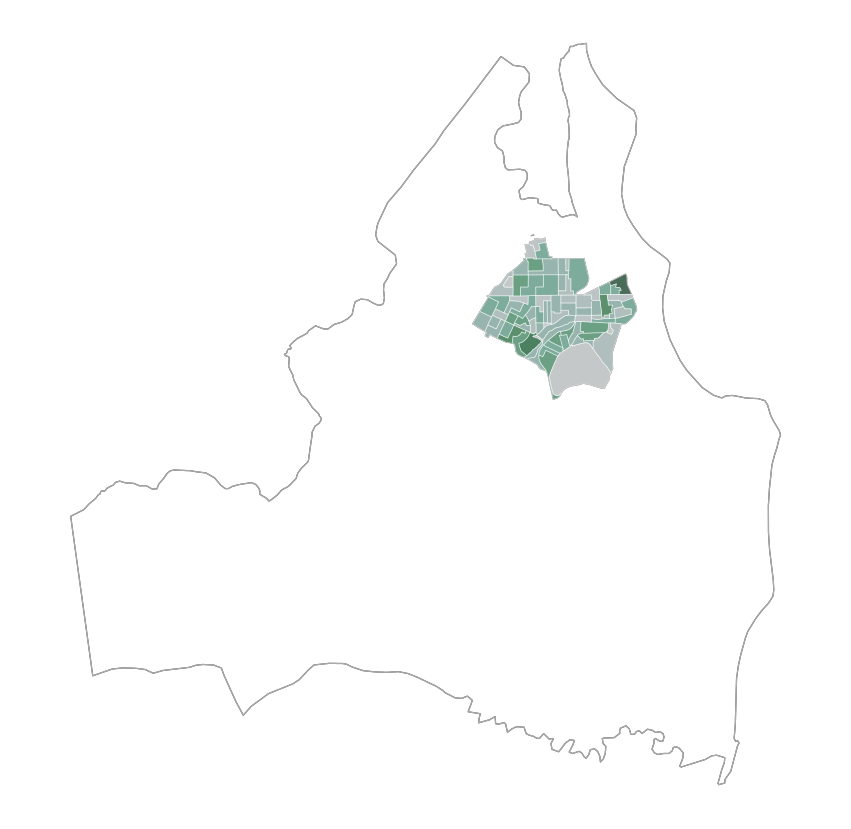

In [12]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = 'none'

bins = get_bins(setores_recorte, 'MORADORES', 10)

cmap = mpl.cm.BuGn
norm = mpl.colors.BoundaryNorm(bins, cmap.N)
fig, ax = plt.subplots()
alpha = 0.7
plt.axis('equal')
ax.set_axis_off()
plot = setores_recorte.plot(column='MORADORES',
            ax=ax,
            cmap='BuGn',
            alpha=alpha,
            linewidth=0.8,
            scheme='user_defined', 
            classification_kwds={'bins':bins},
            edgecolor='#FFFFFF'
           )


cb.outline.set_edgecolor('#ffffff')
cb.dividers.set_linewidth(3)
cax.tick_params(color='none')
border.plot(ax=ax,
            edgecolor='#aaaaaa',
            linewidth=1.2,
            color='none')


# The figure and axes background must be made transparent.
fig.patch.set(alpha=0)
ax.patch.set(alpha=0)
ctx.add_basemap(ax, source=ctx.sources.ST_TONER_LITE, zoom=16)
operator_t.MULTIPLY.patch_artist(plot)  # Use additive blending.

plt.show()